What I want the data to look like 

8 mice
2 conditions
2 states per condition: sedentary and running
100 trials per condition


results are z-scores that range from -3.5 to 3.5 (using the same range as other paper) 

M1 activity primarily modulated by running onset. see similar increases in activity in both conditions. low activity in sendentary state
Amygdala: most cells have higher firing activity during sendentary phase of stress condition compared to sedentary phase of spontaneous running. See big spike in activity at stimulus onset

VTA: relatively slow ramp up in activity preceding spontaneous running onset, whereas rapid spike at or after escape onset 
    - these might be different neuron populations 



want the firing rates to be modulated by my eight factors (i.e cells would fall into one of those groups, and different regiosns would have different proportions of cells within the groups) 





0.64 ± 0.32 neurons per recording site on average
384 channels (aka sites to record from)
10 mm long probe
960 recording sites for 1.0
1250 recording sites for 2.0 probe per shank 
2.0 4 shank spans 0.7 mm



dentate nucleus: 0.8 mm DV

amygdala: ~1.2mm AP, 0.9 mm DV  

M1: 1.3 mm ML, 0.4DV

Going through FF and VTA at an angle with the same probe would cover 2.55 mm. Just gonna say divide the units 50/50


assumptions to make 
- for simplicity, going to assume all regions have equal cell density (very much not true, especially in cortex)

using this atlas to estimate 

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter1d


# Functions

In [27]:
def sites_per_ROI (probe = 1, height = None, length = None):
    ''' height:DV distance, length: AP distance, diagonal, or ML distance'''
    if probe == 1:
        if height == None:
            return("provide height")
        density = 96 #units per mm 
        sites = height*density

    elif probe ==2:
        density = 125
        if length == None:
            return("provide length")
        elif length< 0.7:
            return("ROI length shorter than 4 shank span")
        sites = height*density*4 #because four shanks 
        if sites>384:
            sites = 384
    
    return(sites)
    

In [28]:
def dataframe_to_dict(df):
    return {col: df[col].tolist() for col in df.columns}

#old
def generate_neuron_activity(pre_stim, post_stim, num_cells, mod_prop, trials=10, peak_variability=5, max_variability_after_stimulus=False):
    """
    pre_stim: number of points pre-stim
    post_stim: number of points post stim
    num_cells: the number of cells to generate the time series for 
    mod_prob: the proportion of the cells that show change in activity in response to the stimulus
    trials: the number of repetitions per cell for averaging
    """

    # Total points in time series
    total_points = pre_stim + post_stim
    
    # Generate baseline activity (random z-scores) for all cells across trials
    baseline_activity = np.random.uniform(-3.5, 0.5, (trials, num_cells, total_points))

    # Number of modulated cells, with 5% variance
    mod_cells = round(np.random.normal(mod_prop, .05) * num_cells)

    # Ramp-up before stimulus and ramp-down after stimulus
    ramp_up = np.linspace(0, 3.5, pre_stim)
    ramp_down = np.linspace(3.5, 0, post_stim)
    ramp = np.concatenate((ramp_up, ramp_down))
    
    # Add ramp for modulated cells only across all trials
    baseline_activity[:, :mod_cells + 1] += ramp

    # Calculate the mean time series across trials for each cell
    avg_neural_activity_all = baseline_activity.mean(axis=0)  # Shape: (num_cells, total_points)
    avg_neural_activity_mod = avg_neural_activity_all[:mod_cells]
    
    return avg_neural_activity_all, avg_neural_activity_mod


In [29]:

def generate_neuron_activity(pre_stim, post_stim, num_cells, mod_prop, trials=10, peak_variability=5, max_variability_after_stimulus=False):
    """
    Generate neuron activity time series for multiple cells, with modulated responses to a stimulus.
    
    pre_stim: number of points before stimulus
    post_stim: number of points after stimulus
    num_cells: number of cells to generate time series for 
    mod_prop: proportion of cells that show change in activity in response to the stimulus
    trials: number of repetitions per cell for averaging
    peak_variability: the maximum variability (in time steps) for the peak around the stimulus time
    max_variability_after_stimulus: if True, variability is applied only within 1 time point after the stimulus
    """

    # Total points in the time series
    total_points = pre_stim + post_stim

    # Generate baseline activity (random z-scores) for all cells across trials
    baseline_activity = np.random.uniform(-3.5, 0.5, (trials, num_cells, total_points))

    # Number of modulated cells
    mod_cells = round(np.random.normal(mod_prop, .05) * num_cells)

    # Ramp-up before stimulus and ramp-down after stimulus
    ramp_up = np.linspace(0, 3, pre_stim)
    ramp_down = np.linspace(2, 0, post_stim)
    ramp = np.concatenate((ramp_up, ramp_down))

    # Add variability to the peak time for modulated cells
    for cell in range(mod_cells):  # Loop over modulated cells
        # Randomly choose an offset for the peak time around the stimulus point (pre_stim)
        peak_offset = np.random.randint(-peak_variability, peak_variability + 1)

        # Apply peak offset variability to the pre-stimulus ramp
        ramp_up_offset = np.linspace(0, 3, pre_stim + peak_offset)  # Adjust ramp-up with offset

        # Apply ramp-down after stimulus based on max_variability_after_stimulus flag
        if max_variability_after_stimulus:
            # If variability is only allowed until 1 time point after the stimulus:
            ramp_down_offset = np.linspace(2, 0, post_stim - peak_offset)  # Apply variability to ramp-down but limit to 1 after stimulus
            ramp_offset = np.concatenate((ramp_up_offset, ramp_down_offset[:1]))  # Only include 1 post-stimulus point
        else:
            ramp_down_offset = np.linspace(2, 0, post_stim - peak_offset)  # Apply variability to ramp-down
            ramp_offset = np.concatenate((ramp_up_offset, ramp_down_offset))

        # Ensure the ramp does not exceed the total length
        ramp_offset = ramp_offset[:total_points]  # Ensure it doesn't exceed the total length
        
        # If ramp_offset is shorter than expected, pad it with zeros to match the total length
        if len(ramp_offset) < total_points:
            ramp_offset = np.pad(ramp_offset, (0, total_points - len(ramp_offset)), 'constant', constant_values=0)
        
        # Add the modified ramp to the modulated cells across all trials
        baseline_activity[:, cell] += ramp_offset

    # Calculate the mean time series across trials for each cell
    avg_neural_activity_all = baseline_activity.mean(axis=0)  # Shape: (num_cells, total_points)
    avg_neural_activity_mod = avg_neural_activity_all[:mod_cells] #also making it so can isolate just the modulated cells
    
    return avg_neural_activity_all,avg_neural_activity_mod


old
# Function to calculate the peak response time for each neuron
def get_peak_time(time_series, pre_stim_points):
    # Find the time point where the response is maximal (post-stimulus)
    post_stim_series = time_series[pre_stim_points:]
    peak_time = np.argmax(post_stim_series) + pre_stim_points  # + pre_stim_points to adjust index
    return peak_time

In [30]:

# Function to calculate the peak response time for each neuron
def get_peak_times(neural_activity_array):
    peak_times = []
    for array in neural_activity_array:
        np.array(peak_times.append(np.argmax(array))) 
    return peak_times

In [31]:
def smooth_time_series(time_series, sigma=1.0):
    # Apply Gaussian filter to smooth the time series
    return gaussian_filter1d(time_series, sigma=sigma)

# Calculate Number of cells per animal per region

In [32]:
probe1_rois = {"DN":0.8, "FF":2.55/2, "VTA": 2.55/2} #dictionary with the regions and the amount of recording distance per region
probe2_rois = {"CeA":(0.9,1.2), "M1":(0.4, 1.3)}# dictionary with the regions and the amount of recording distance and width


In [33]:
rois = []
sites = []

probe = 1 
for roi in probe1_rois.keys():
    rois.append(roi)
    height = probe1_rois[roi]
    site_num = sites_per_ROI(probe,height)
    sites.append(round(site_num))

probe =2
for roi in probe2_rois.keys():
    rois.append(roi)
    height = probe2_rois[roi][0]
    length = probe2_rois[roi][1]
    site_num = sites_per_ROI(probe,height, length)
    sites.append(round(site_num))

sites_per_roi = dict(zip(rois,sites))

In [34]:
sites_per_roi

{'DN': 77, 'FF': 122, 'VTA': 122, 'CeA': 384, 'M1': 200}

In [35]:
#calculating how many single units I would get from each site based on the efficiency of the probes

single_units = []
animals = list(range(0,8))
for animal in animals: #simulating recording accross 8 animals
    np.random.seed(animal)#setting the seed for the random number generator so each time it is the same in this instance
    
    mean = 0.64 #number of neurons per recording site usually
    stdev = 0.32
    units = []
    
    units = np.random.normal(mean, stdev, 5) #generating a random number of neurons detected per site accross the five regions

    
    units_per_site = units*(np.array(sites))
    units_per_site = np.clip(units_per_site, 0, None)  # Values less than 0 will be clipped to 0

    single_units.append(units_per_site.round()) #rounding to whole numbers 

np.random.seed(seed = None) #unseeding things just in case 

In [36]:
#cprpa = cells per region per animal
#made dataframe of the number of cells per each region per animal
cprpaDF = pd.DataFrame(data = single_units, columns = rois)

#cpr: cells per region. Getting the total number of cells per region. dropping the animal column

#reducing the number of cells to analyze by expected proportion that would be task modulated
prop_mod  = {"DN": .75,
    "FF": .5,
    "VTA": 0.7,
    "CeA": 0.7,
    "M1": .6}

cprpaDF_pm = cprpaDF #pm = paradigm modulated

for col in cprpaDF.columns:
    prop = prop_mod[col]
    cprpaDF_pm[col] = (cprpaDF[col]*prop)

cprpaDF_pm = cprpaDF_pm.round()

cpr= cprpaDF_pm.sum()


In [37]:
sites_per_roi

{'DN': 77, 'FF': 122, 'VTA': 122, 'CeA': 384, 'M1': 200}

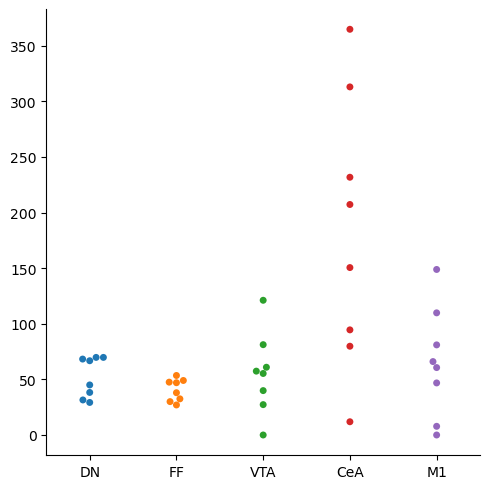

In [38]:
g = sns.catplot(data = cprpaDF, kind = "swarm")

g.ylabel = "Number Cells"

plt.show()

#different distributions by region because the potential number of recording sites per region varies?
# the weird gap in the DN data is probably because I am limiting the outcome to whole numbers

/var/folders/ct/qztxmsdn1t7gbywqlzpynx1m0000gp/T/ipykernel_63163/363523870.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(data=long_df, x="index", y="Value", color='red', ci='sd', capsize=0.2, join=False)
/var/folders/ct/qztxmsdn1t7gbywqlzpynx1m0000gp/T/ipykernel_63163/363523870.py:7: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=long_df, x="index", y="Value", color='red', ci='sd', capsize=0.2, join=False)


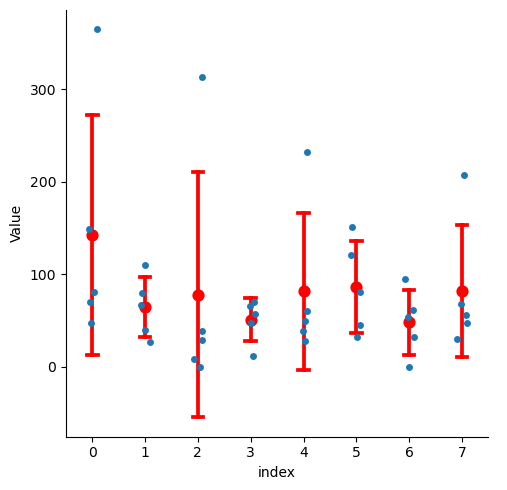

In [39]:
long_df = cprpaDF.reset_index().melt(id_vars="index", var_name="Variable", value_name="Value")

# Plot each row as an x-axis category with individual points from each row
sns.catplot(data=long_df, x="index", y="Value", kind="strip")

# Overlay the mean and standard deviation for each x-axis row index
sns.pointplot(data=long_df, x="index", y="Value", color='red', ci='sd', capsize=0.2, join=False)

# Display the plot
plt.show()

proportion that are paradigm modulated per region on average 
DN: 75% (of this, about 90% respond to running onset, and of that group 10% respond only in condition 1, and 60% respond in both conditions but respond more strongly to running onset in condition 1) 
M1: 60% (of this, 80% respond to running onset in both conditions, and 15% are responding only in condition 2) 
VTA: 70%
CeA: 70% 
FF: 50%



In [40]:
neuron_counts = dataframe_to_dict(cprpaDF_pm)

In [41]:
neuron_counts

{'DN': [70.0, 67.0, 29.0, 70.0, 38.0, 45.0, 32.0, 68.0],
 'FF': [47.0, 27.0, 38.0, 48.0, 49.0, 32.0, 54.0, 30.0],
 'VTA': [81.0, 40.0, 0.0, 57.0, 27.0, 121.0, 61.0, 55.0],
 'CeA': [365.0, 80.0, 313.0, 12.0, 232.0, 150.0, 94.0, 207.0],
 'M1': [149.0, 110.0, 8.0, 66.0, 61.0, 81.0, 0.0, 47.0]}

In [42]:
pre_stim_points = 10
post_stim_points = 10
total_points = pre_stim_points + post_stim_points
z_score_range = (-3.5, 3.5)
#response_proportion = 0.7  # 70% of neurons respond
rois_response_base = {"DN":0.75, "M1": 0.6, "VTA": 0.7, "CeA": 0.7, "FF":0.5}

In [43]:
list(enumerate(zip(*neuron_counts.values())))

[(0, (70.0, 47.0, 81.0, 365.0, 149.0)),
 (1, (67.0, 27.0, 40.0, 80.0, 110.0)),
 (2, (29.0, 38.0, 0.0, 313.0, 8.0)),
 (3, (70.0, 48.0, 57.0, 12.0, 66.0)),
 (4, (38.0, 49.0, 27.0, 232.0, 61.0)),
 (5, (45.0, 32.0, 121.0, 150.0, 81.0)),
 (6, (32.0, 54.0, 61.0, 94.0, 0.0)),
 (7, (68.0, 30.0, 55.0, 207.0, 47.0))]

In [44]:
nested_list = list(neuron_counts.values())
flat_list = [item for sublist in nested_list for item in sublist]
sum(flat_list)

3161.0

# Generate neuron data for each animal and region

def roi_neuron_activity(rois_responseprop = rois_responseprop, all_cells = True, increase_proportion = 0.9):
    ''' rois_responseprop: the proportion of cells that are modulated by the task, by roi. this is a dictionary
        all_cells: whether or not to include only cells modulated by the task 
        increase_proportion: proportion of cells that increase ramp up pre-running onset (should be a dictionary based on roi as well) 
    '''
    all_neuron_data = []
    neuron_id_counter = 0  # Start a counter for unique neuron IDs
    
    for animal_id, (dn, ff, vta, cea, m1) in enumerate(zip(*neuron_counts.values())):
        for region, num_neurons in zip(["DN", "FF", "VTA", "CeA", "M1"], [dn, ff, vta, cea, m1]):
            # Generate time series for neurons in this region
            response_proportion = rois_responseprop[region]
            time_series_all, time_series_mod = generate_neuron_activity(pre_stim_points, post_stim_points, int(num_neurons), 
                                                   response_proportion, max_variability_after_stimulus=True)
            
            # Calculate peak times for each neuron in the generated time series
            if all_cells == True:
                time_series = time_series_all
            else:
                time_series = time_series_mod
           
            peak_times = get_peak_times(time_series)

            # Filter neurons based on increase_proportion
            num_neurons_to_increase = int(len(peak_times) * increase_proportion)
            
            # Ensure peak time is before stimulus for selected neurons
            for i in range(num_neurons_to_increase):
                if peak_times[i] >= pre_stim_points:
                    peak_times[i] = np.random.randint(0, pre_stim_points) #Assign a new peak before stimulus

            
            # Append each neuron’s data with region, time series, peak time, and unique neuron ID
            for neuron_series, peak_time in zip(time_series, peak_times):
                all_neuron_data.append((region, neuron_id_counter, neuron_series, peak_time))
                neuron_id_counter += 1  # Increment neuron ID for the next neuron
    
    return all_neuron_data

In [68]:
# Generate neuron data for each animal and region

def roi_neuron_activity(rois_responseprop = rois_response_base, all_cells = True):
    ''' rois_responseprop: the proportion of cells that are modulated by the task, by roi. this is a dictionary
        all_cells: whether or not to include only cells modulated by the task 
        increase_proportion: proportion of cells that increase ramp up pre-running onset (should be a dictionary based on roi as well) 
    '''
    all_neuron_data = []
    neuron_id_counter = 0  # Start a counter for unique neuron IDs
    
    for animal_id, (dn, ff, vta, cea, m1) in enumerate(zip(*neuron_counts.values())):
        for region, num_neurons in zip(["DN", "FF", "VTA", "CeA", "M1"], [dn, ff, vta, cea, m1]):
            # Generate time series for neurons in this region
            response_proportion = rois_responseprop[region]
            time_series_all, time_series_mod = generate_neuron_activity(pre_stim_points, post_stim_points, int(num_neurons), 
                                                   response_proportion, max_variability_after_stimulus=True)
            
            # Calculate peak times for each neuron in the generated time series
            if all_cells == True:
                time_series = time_series_all
            else:
                time_series = time_series_mod
           
            peak_times = get_peak_times(time_series)

            
            # Append each neuron’s data with region, time series, peak time, and unique neuron ID
            for neuron_series, peak_time in zip(time_series, peak_times):
                all_neuron_data.append((region, neuron_id_counter, neuron_series, peak_time))
                neuron_id_counter += 1  # Increment neuron ID for the next neuron
    
    return all_neuron_data

In [69]:
all_neuron_data = roi_neuron_activity()

def heatmap_conversion (data = all_neuron_data):
    # Sort all neurons by region and peak response time
    data.sort(key=lambda x: (x[0], x[3]))  # Sort by region, then by peak_time
    
    # Prepare data for the heatmap
    sorted_time_series = []
    sorted_labels = []
    
    # Create a list of sorted time series and labels
    current_region = None
    for region, neuron_id, time_series, peak_time in data:
        # Only add a region label once for each group of neurons
        if region != current_region:
            sorted_labels.append(region)  # Append the region label
            current_region = region
        
        sorted_time_series.append(time_series)
    
    # Convert list to a NumPy array for heatmap
    heatmap_data = np.array(sorted_time_series)
    return heatmap_data


In [70]:
def plot_region_heatmaps(data = all_neuron_data , neuron_counts = neuron_counts, pre_stim_points = pre_stim_points):
    # Initialize a dictionary to organize time series by region
    region_time_series = {region: [] for region in neuron_counts.keys()}
    
    # Populate the region_time_series dictionary with sorted time series from `all_neuron_data`
    for region, neuron_id, time_series, peak_time in data:
        # Append each time series and its peak time to the respective region list
        region_time_series[region].append((time_series, peak_time))

    # Sort the time series within each region by peak time
    for region, data in region_time_series.items():
        # Sort by peak time
        data.sort(key=lambda x: x[1])  
        # Replace each entry in the region with just the time series (remove peak times)
        region_time_series[region] = [x[0] for x in data]

    # Create subplots for each region
    fig, axes = plt.subplots(nrows=1, ncols=len(region_time_series), figsize=(20, 8))
    
    for i, (ax, (region, time_series_list)) in enumerate(zip(axes, region_time_series.items())):
        # Convert the list of time series for the region into a NumPy array
        heatmap_data = np.array(time_series_list)
        
        # Plot heatmap without colorbar for all but the last subplot
        sns.heatmap(heatmap_data, cmap='coolwarm', cbar=(i == len(region_time_series) - 1), 
                    cbar_kws={'label': 'Z-score'} if i == len(region_time_series) - 1 else None, 
                    xticklabels=False, yticklabels=False, ax=ax)
        
        # Add a vertical dotted line at time point 0 (pre-stimulus)
        ax.axvline(x=pre_stim_points, color='black', linestyle='--', linewidth=1)
        
        # Set the title for the region
        ax.set_title(f"{region}")
    
    # Adjust layout and show the figure
    plt.tight_layout()
    plt.show()

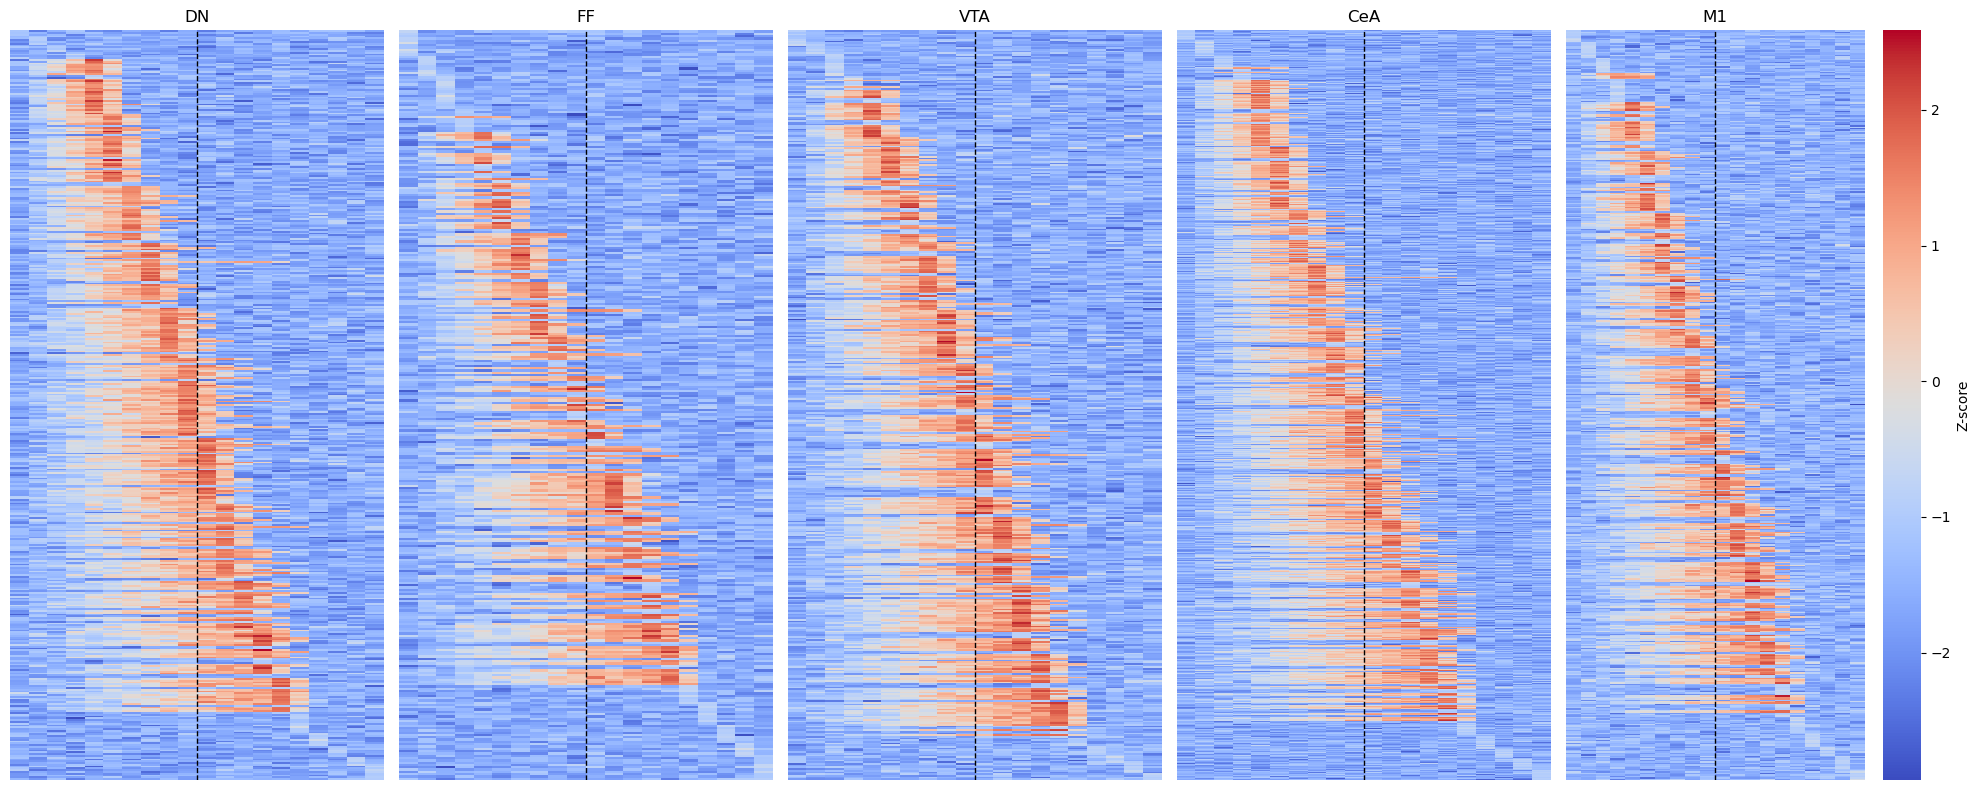

In [71]:
plot_region_heatmaps()

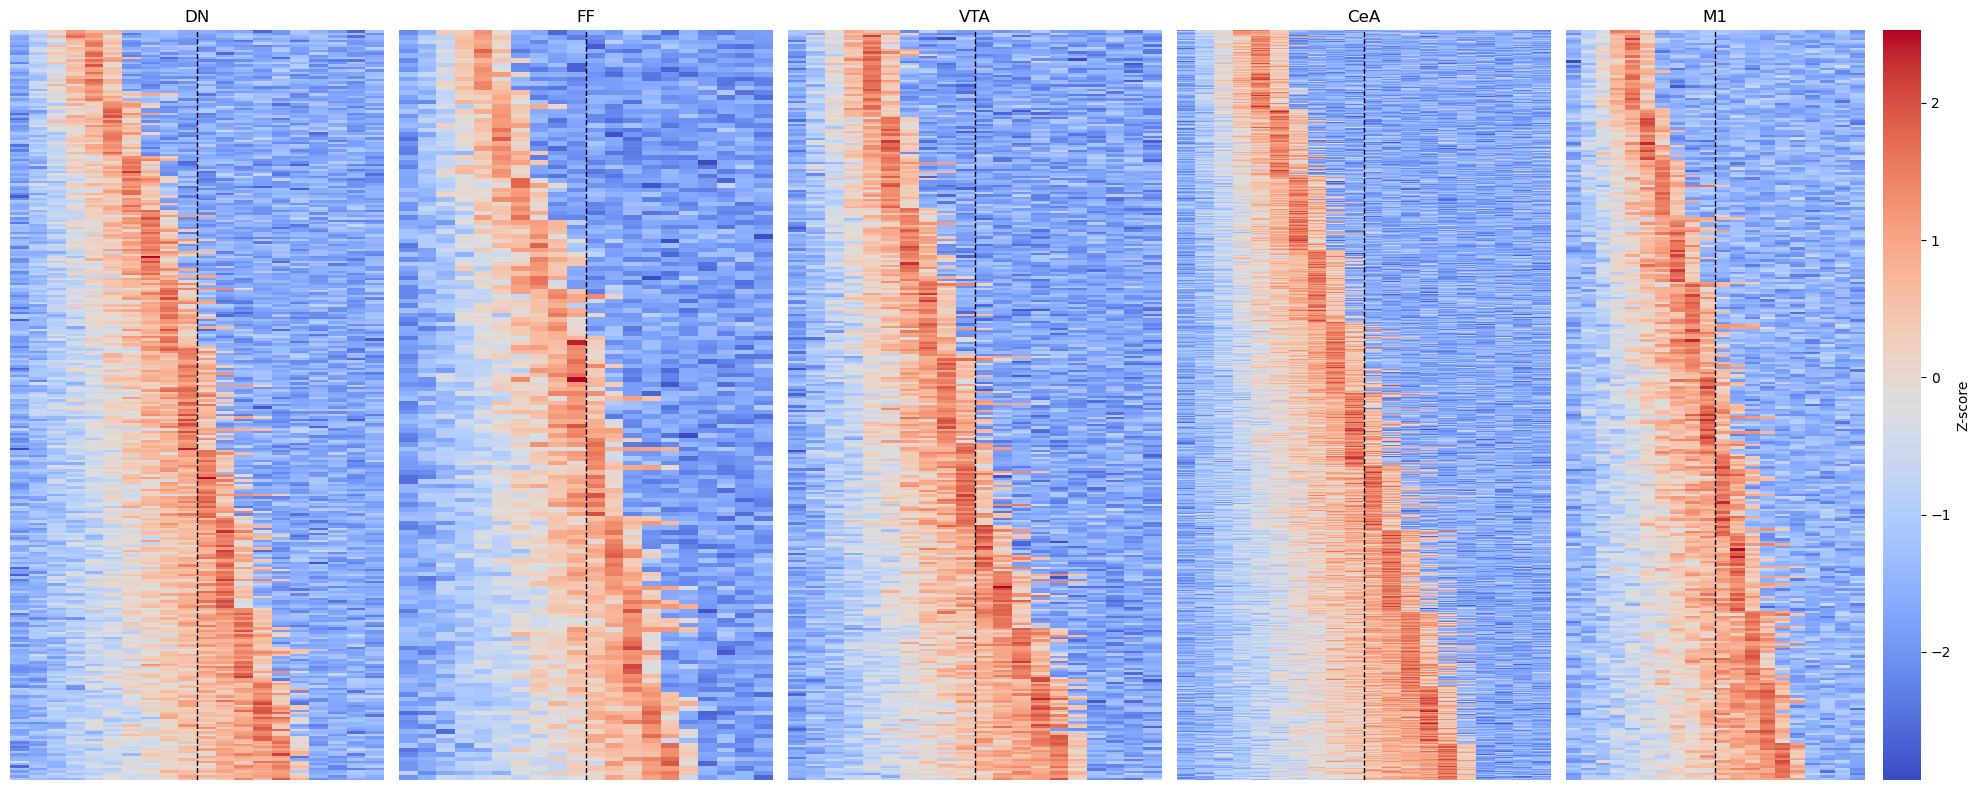

In [72]:
mod_neuron_data = roi_neuron_activity(all_cells=False)
heatmap_data  = heatmap_conversion(mod_neuron_data)

# Convert `all_neuron_data` from block 1 into a dictionary format organized by region
region_time_series = {region: [] for region in neuron_counts.keys()}

# Populate the region_time_series dictionary with sorted time series from `all_neuron_data`
for region, neuron_id, time_series, peak_time in mod_neuron_data:
    # Smooth the time series if necessary
    #smoothed_time_series = smooth_time_series(time_series)
    region_time_series[region].append((time_series, peak_time))

# Sort the time series within each region by peak time
for region, data in region_time_series.items():
    # Sort by peak time
    data.sort(key=lambda x: x[1])  
    
    # Replace each entry in the region with just the smoothed time series (removing peak times)
    region_time_series[region] = [x[0] for x in data]

# Create subplots: one for each region
fig, axes = plt.subplots(nrows=1, ncols=len(region_time_series), figsize=(20, 8))

for i, (ax, (region, time_series_list)) in enumerate(zip(axes, region_time_series.items())):
    # Convert the list of time series for the region into a NumPy array
    heatmap_data = np.array(time_series_list)
    
    # Plot heatmap without colorbar for now
    sns.heatmap(heatmap_data, cmap='coolwarm', cbar=False, xticklabels=False, yticklabels=False, ax=ax)
    
    # Add a vertical dotted line at time point 0 (pre-stimulus)
    ax.axvline(x=pre_stim_points, color='black', linestyle='--', linewidth=1)
    
    # Set the title for the region
    ax.set_title(f"{region}")
    
    # If it's the last subplot (region), add the colorbar
    if i == len(region_time_series) - 1:
        sns.heatmap(heatmap_data, cmap='coolwarm', cbar_kws={'label': 'Z-score'}, xticklabels=False, yticklabels=False, ax=ax)

# Adjust the layout and display the figure
plt.tight_layout()
plt.show()


In [73]:
# Calculate the total number of time series across all regions
total_time_series = sum(len(time_series) for time_series in region_time_series.values())

print("Total number of time series:", total_time_series)


Total number of time series: 2085


In [74]:
# Calculate the number of time series per region
time_series_per_region = {region: len(time_series) for region, time_series in region_time_series.items()}

print("Number of time series per region:", time_series_per_region)


Number of time series per region: {'DN': 309, 'FF': 162, 'VTA': 320, 'CeA': 993, 'M1': 301}


In [75]:
cpr

DN      419.0
FF      325.0
VTA     442.0
CeA    1453.0
M1      522.0
dtype: float64

In [85]:
C1_response_prop= {"DN":0.75, "M1": (0.6*0.85), "VTA": 0.7, "CeA": (0.7*0.5), "FF":0.5}
C2_response_prop= {"DN":0.75*.5, "M1": 0.6, "VTA": 0.7, "CeA": (0.7), "FF":(0.5*0.6)}

In [86]:
C1_activity = roi_neuron_activity(rois_responseprop= C1_response_prop) 
C2_activity = roi_neuron_activity(rois_responseprop= C2_response_prop) 

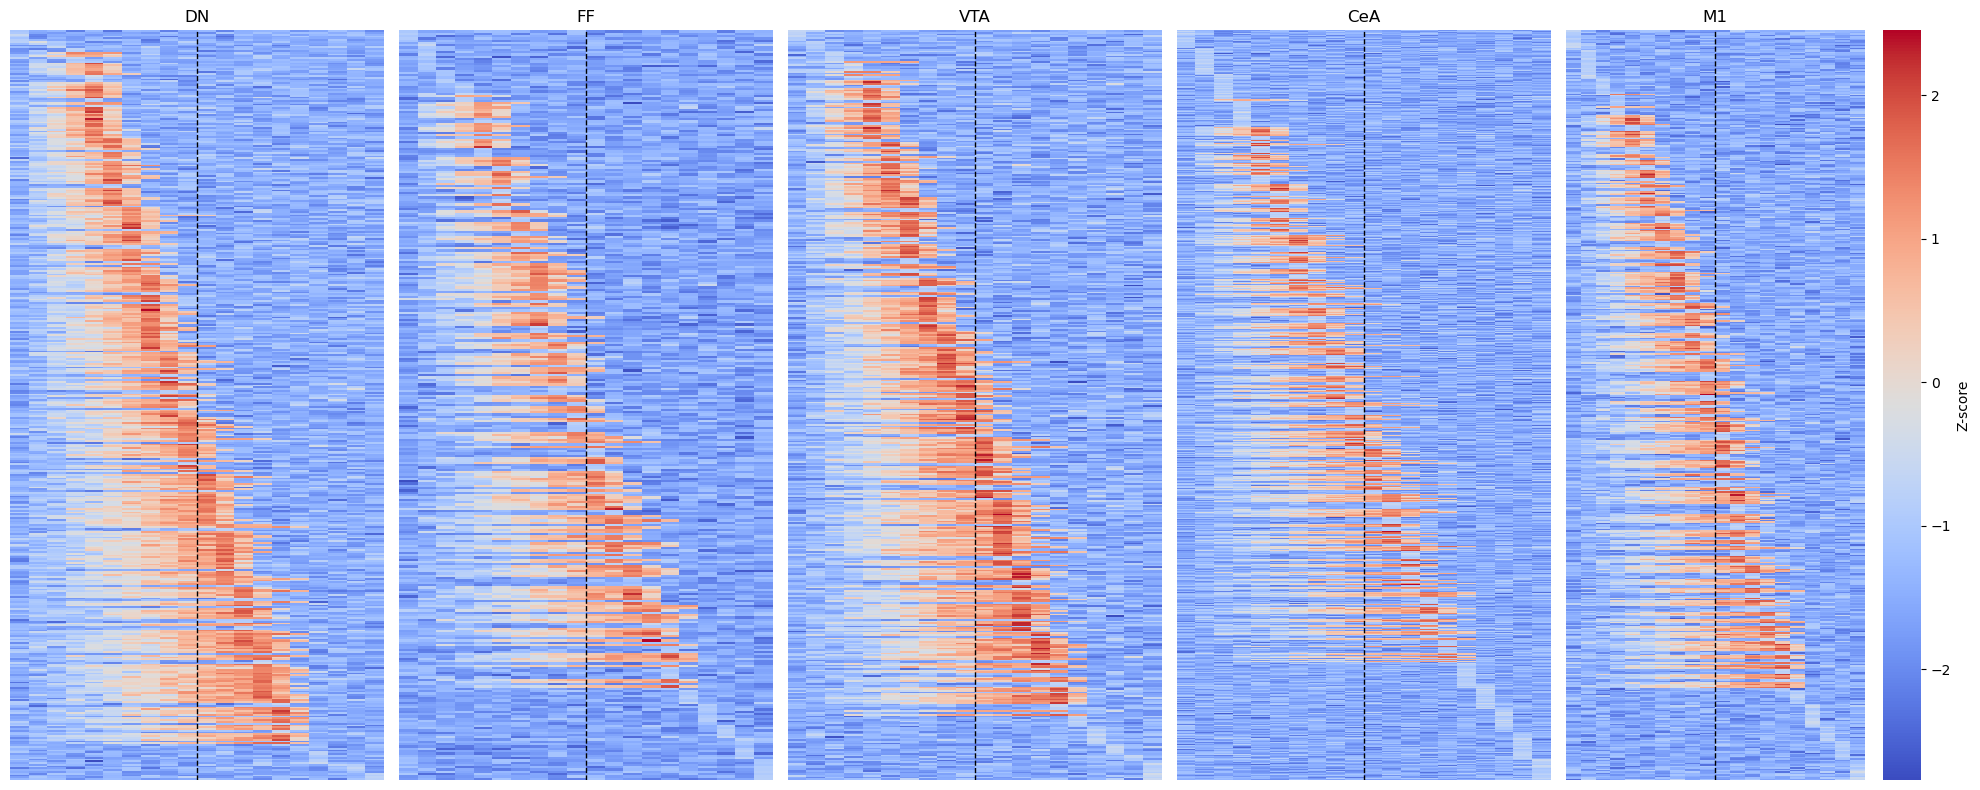

In [87]:
plot_region_heatmaps(data = C1_activity)

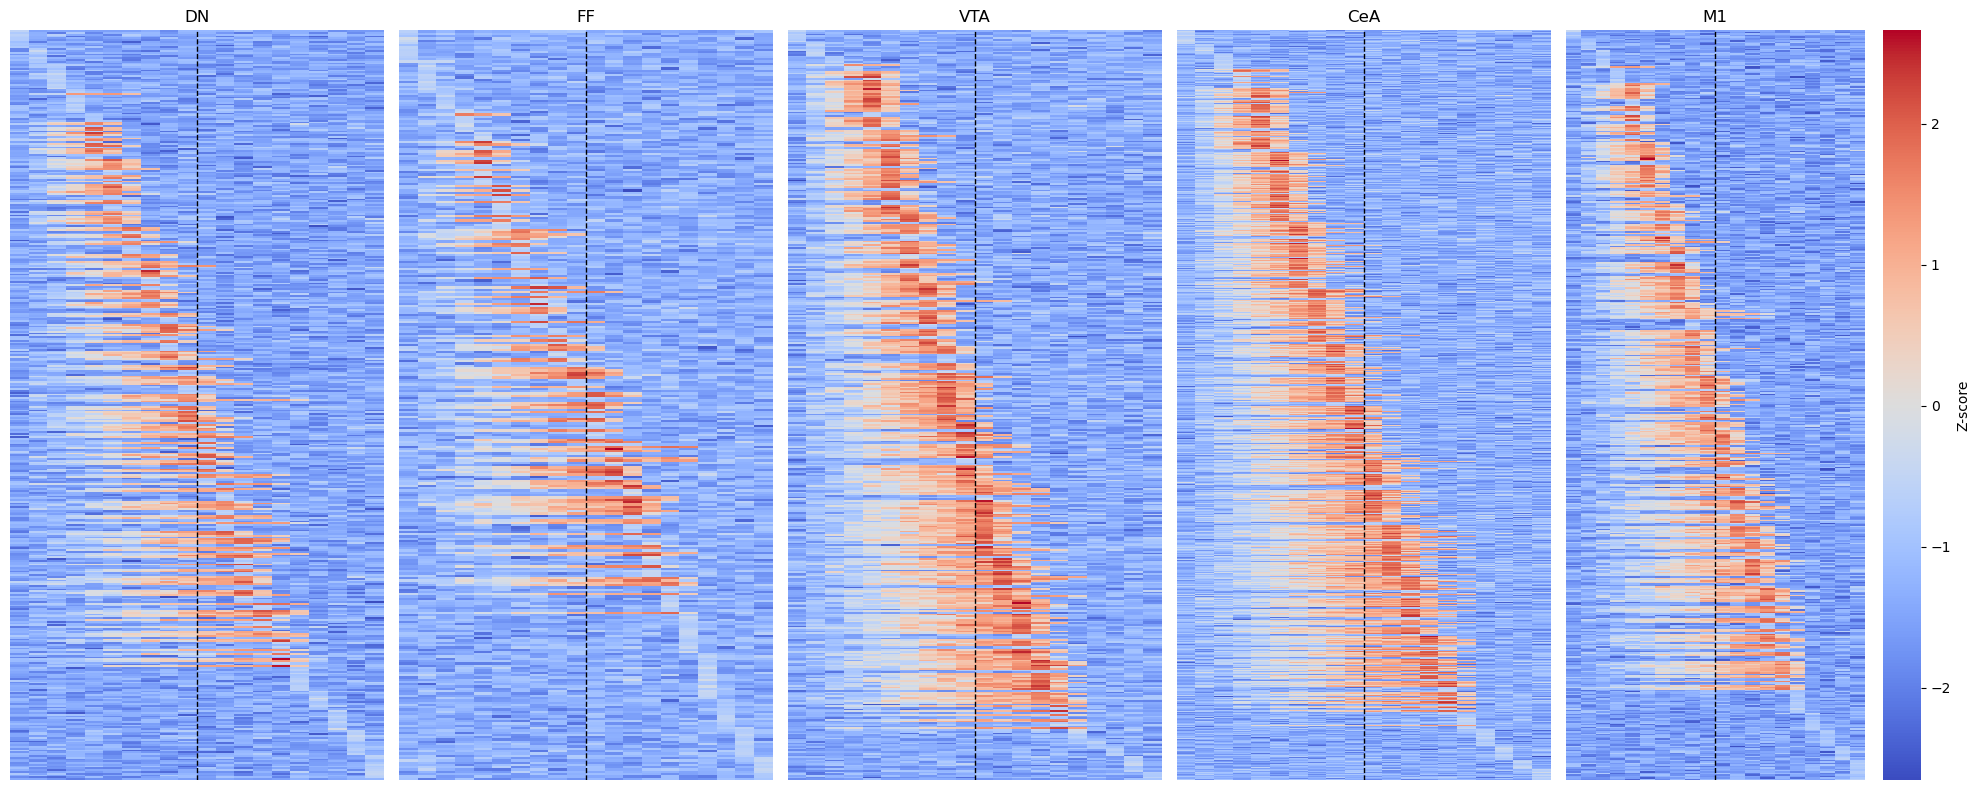

In [88]:
plot_region_heatmaps(data = C2_activity)

In [90]:
C2_activity

[('DN',
  0,
  array([-1.16045779e+00, -1.01133494e+00,  9.94783347e-04,  3.42913937e-02,
          1.40177370e+00,  1.92031846e+00,  5.44516631e-01, -1.59809136e+00,
         -1.75661134e+00, -1.72723173e+00, -1.49944694e+00, -1.61168737e+00,
         -1.47093870e+00, -1.40056212e+00, -1.37740760e+00, -1.20183288e+00,
         -1.39396900e+00, -2.01932492e+00, -1.48945164e+00, -1.74120556e+00]),
  5),
 ('DN',
  1,
  array([-1.72581632, -1.32651546, -0.24394811,  0.58474081,  0.3696802 ,
          0.72846821,  0.6159081 ,  1.04568941,  1.03507814, -1.46190018,
         -1.61699351, -2.1321067 , -0.9021838 , -1.77328149, -1.72307319,
         -1.88168311, -1.17328409, -1.46106668, -1.60665769, -1.52221043]),
  7),
 ('DN',
  2,
  array([-1.56690811, -1.82997626, -0.42878613, -0.65406875,  0.13742056,
         -0.26469806,  0.49027413,  0.8267983 ,  0.82480185,  1.07217326,
          0.89346391,  0.73079561, -1.48711795, -1.91654914, -1.51402307,
         -1.71234673, -1.87593527, -2.0036

In [103]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

def prepare_clustering_data(C1_activity, C2_activity):
    # Concatenate time series for each cell across the two conditions
    combined_activity = []
    for (region1, neuron_id1, ts1, peak_time1), (region2, neuron_id2, ts2, peak_time2) in zip(C1_activity, C2_activity):
        # Assuming each neuron is matched by ID across both conditions
        combined_ts = np.concatenate([ts1, ts2])
        combined_activity.append(combined_ts)
    
    # Convert to array
    combined_activity = np.array(combined_activity)
    
    # Normalize data
    scaler = StandardScaler()
    #normalized_activity = scaler.fit_transform(combined_activity)
    
    return combined_activity

def cluster_cells(normalized_activity, n_clusters=3):
    # Dimensionality reduction (optional but recommended)
    pca = PCA(n_components=10)  # Adjust components based on variance explained
    reduced_activity = pca.fit_transform(normalized_activity)
    
    # Clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    clusters = kmeans.fit_predict(reduced_activity)
    
    return clusters

# Prepare data and perform clustering
normalized_activity = prepare_clustering_data(C1_activity, C2_activity)
clusters = cluster_cells(normalized_activity, n_clusters=12)

# Output cluster labels for each cell
print("Cluster assignments:", clusters)


Cluster assignments: [11  1  1 ...  2  2  2]


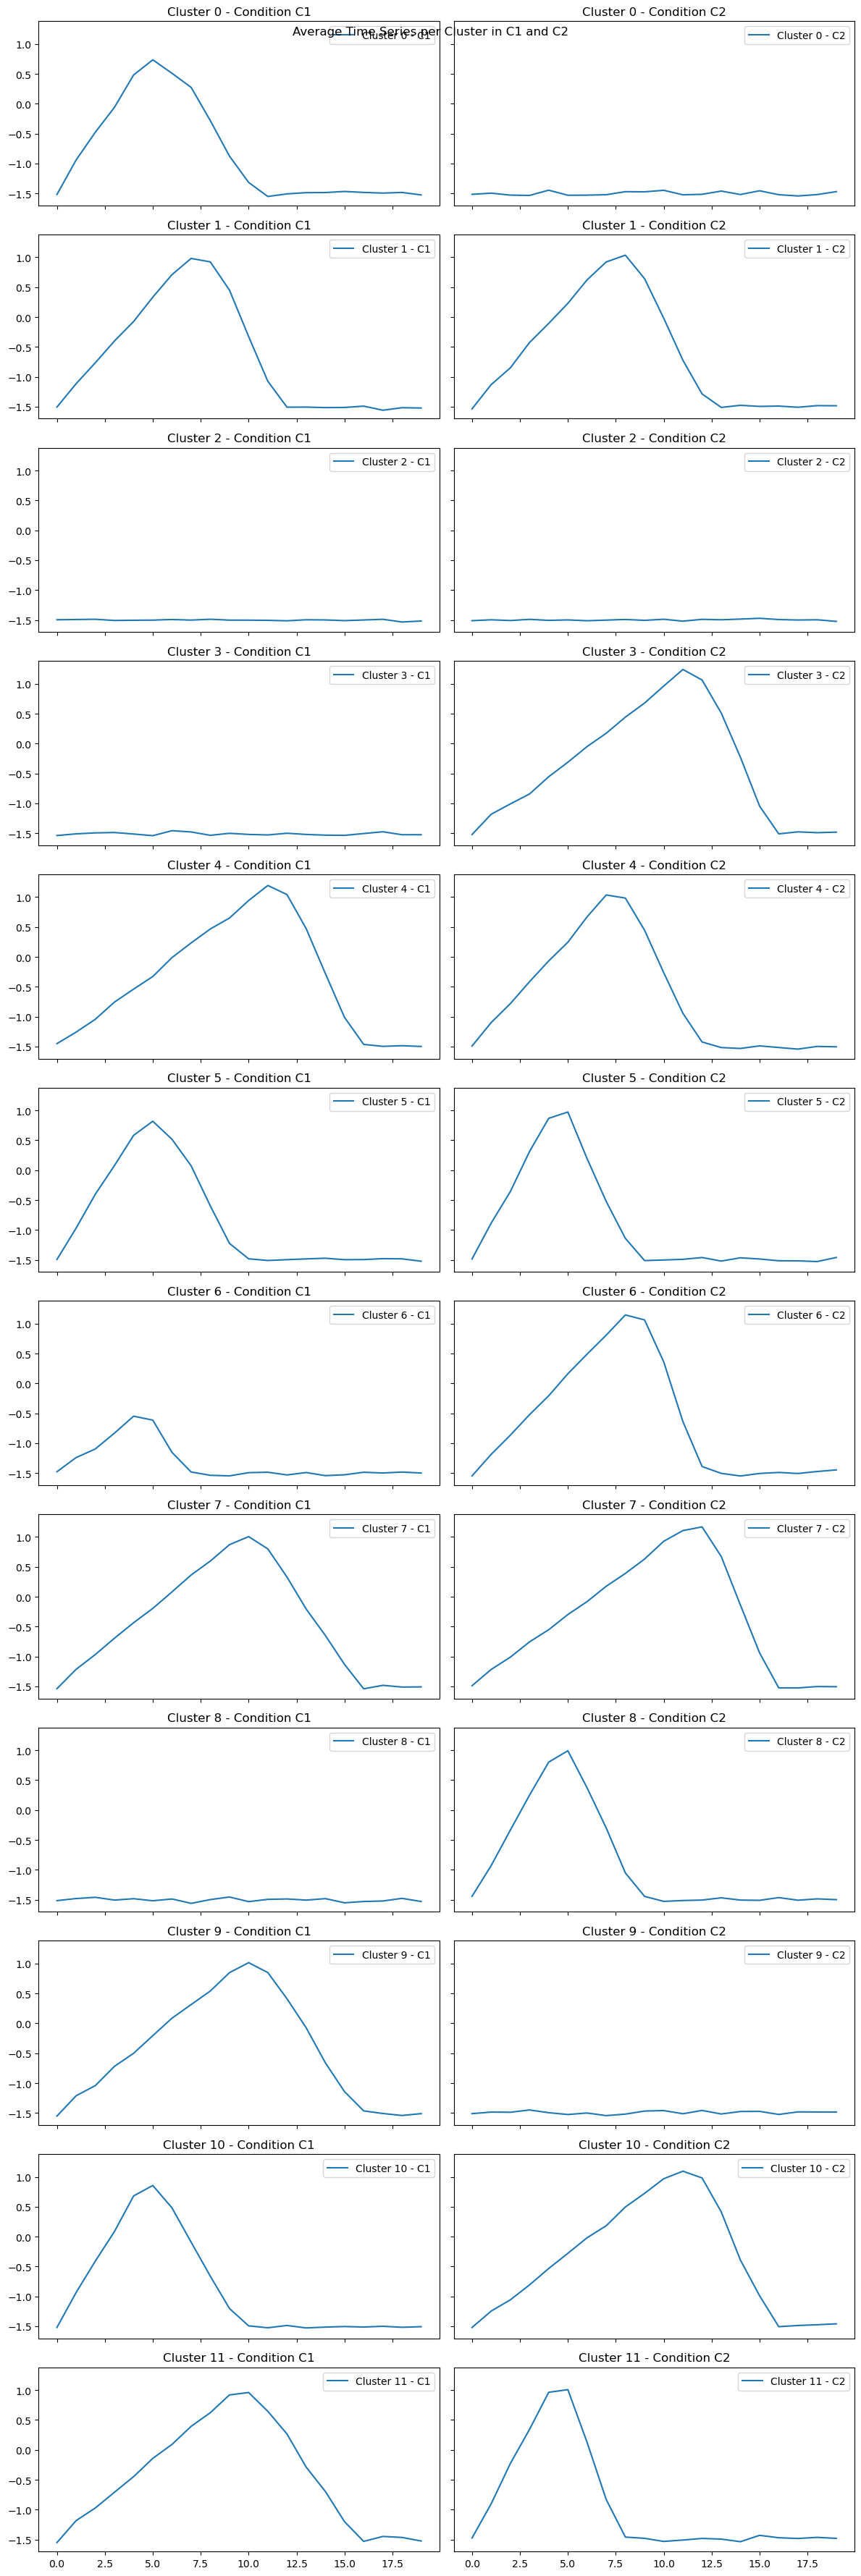

In [104]:
from collections import defaultdict

def get_cluster_average_time_series(C1_activity, C2_activity, clusters):
    # Determine the number of clusters
    n_clusters = len(set(clusters))

    # Initialize dictionaries to hold time series for each cluster in each condition
    C1_cluster_data = defaultdict(list)
    C2_cluster_data = defaultdict(list)

    # Separate cells by cluster
    for (region1, neuron_id1, ts1, peak_time1), (region2, neuron_id2, ts2, peak_time2), cluster_id in zip(C1_activity, C2_activity, clusters):
        C1_cluster_data[cluster_id].append(ts1)
        C2_cluster_data[cluster_id].append(ts2)

    # Compute the average time series for each cluster in each condition
    C1_cluster_avg = {}
    C2_cluster_avg = {}
    for cluster_id in range(n_clusters):
        C1_cluster_avg[cluster_id] = np.mean(C1_cluster_data[cluster_id], axis=0)
        C2_cluster_avg[cluster_id] = np.mean(C2_cluster_data[cluster_id], axis=0)
    
    return C1_cluster_avg, C2_cluster_avg

# Assuming `clusters` is a list with the cluster assignments for each cell
C1_cluster_avg, C2_cluster_avg = get_cluster_average_time_series(C1_activity, C2_activity, clusters)

# Plotting as before
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(C1_cluster_avg), 2, figsize=(12, 3 * len(C1_cluster_avg)), sharex=True, sharey=True)
for cluster_id in range(len(C1_cluster_avg)):
    axes[cluster_id, 0].plot(C1_cluster_avg[cluster_id], label=f'Cluster {cluster_id} - C1')
    axes[cluster_id, 1].plot(C2_cluster_avg[cluster_id], label=f'Cluster {cluster_id} - C2')
    
    # Add titles and legends
    axes[cluster_id, 0].set_title(f'Cluster {cluster_id} - Condition C1')
    axes[cluster_id, 1].set_title(f'Cluster {cluster_id} - Condition C2')
    axes[cluster_id, 0].legend()
    axes[cluster_id, 1].legend()

plt.suptitle('Average Time Series per Cluster in C1 and C2')
plt.tight_layout()
plt.show()


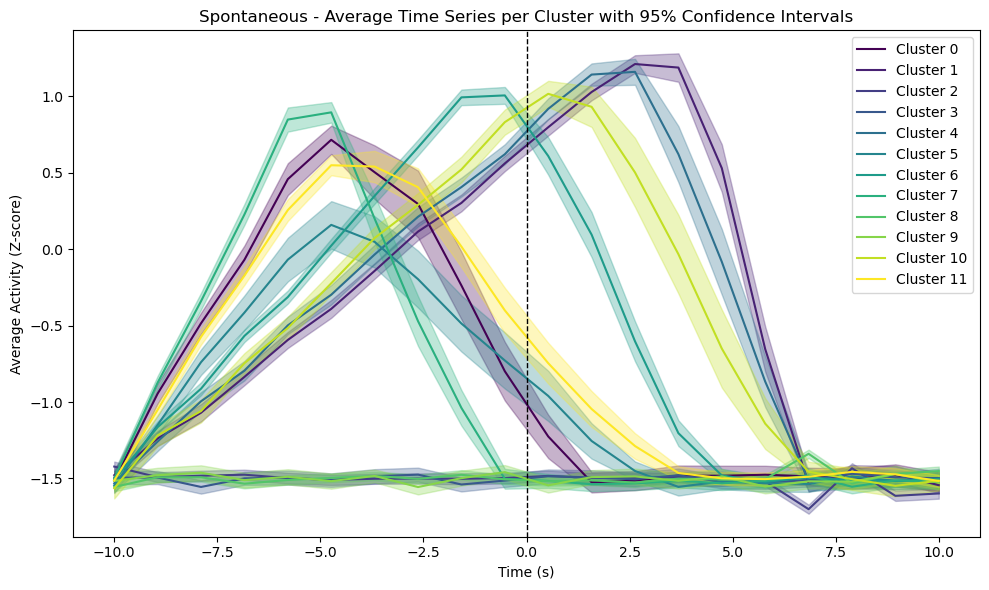

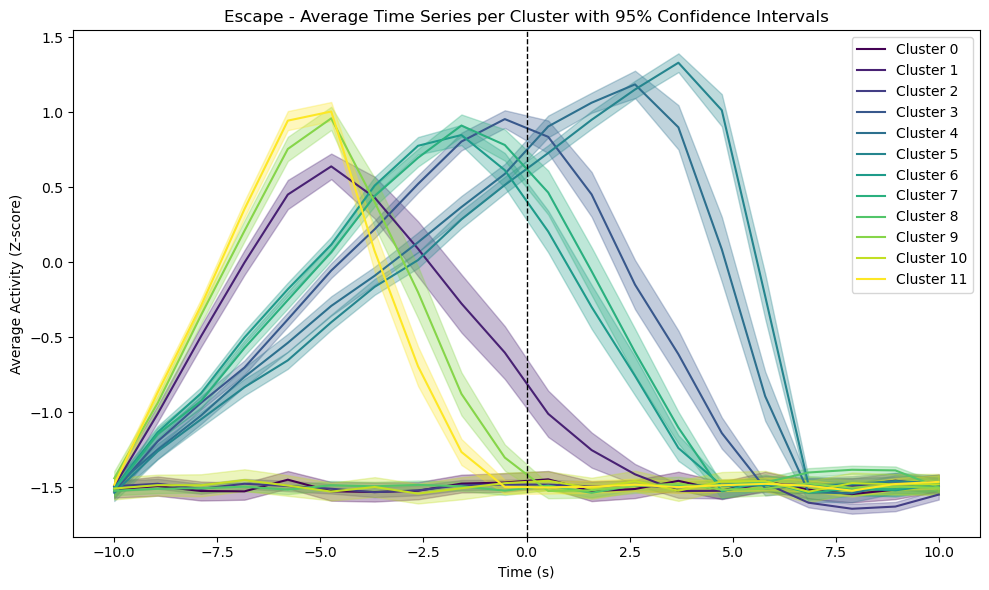

In [101]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import sem

def get_cluster_average_time_series(C1_activity, C2_activity, clusters):
    # Determine the number of clusters
    n_clusters = len(set(clusters))

    # Initialize dictionaries to hold time series for each cluster in each condition
    C1_cluster_data = defaultdict(list)
    C2_cluster_data = defaultdict(list)

    # Separate cells by cluster
    for (region1, neuron_id1, ts1, peak_time1), (region2, neuron_id2, ts2, peak_time2), cluster_id in zip(C1_activity, C2_activity, clusters):
        C1_cluster_data[cluster_id].append(ts1)
        C2_cluster_data[cluster_id].append(ts2)

    # Compute the average and SEM (for confidence intervals) time series for each cluster
    C1_cluster_avg = {}
    C2_cluster_avg = {}
    C1_cluster_sem = {}
    C2_cluster_sem = {}
    for cluster_id in range(n_clusters):
        C1_cluster_avg[cluster_id] = np.mean(C1_cluster_data[cluster_id], axis=0)
        C2_cluster_avg[cluster_id] = np.mean(C2_cluster_data[cluster_id], axis=0)
        C1_cluster_sem[cluster_id] = sem(C1_cluster_data[cluster_id], axis=0)
        C2_cluster_sem[cluster_id] = sem(C2_cluster_data[cluster_id], axis=0)
    
    return C1_cluster_avg, C2_cluster_avg, C1_cluster_sem, C2_cluster_sem

# Get the average and SEM time series for each cluster
C1_cluster_avg, C2_cluster_avg, C1_cluster_sem, C2_cluster_sem = get_cluster_average_time_series(C1_activity, C2_activity, clusters)

# Define x-axis time points
time_points = np.linspace(-10, 10, C1_cluster_avg[0].shape[0])

# Define colors for clusters
colors = plt.cm.viridis(np.linspace(0, 1, len(C1_cluster_avg)))

# Plotting for C1 ("Spontaneous")
plt.figure(figsize=(10, 6))
for cluster_id, color in enumerate(colors):
    plt.plot(time_points, C1_cluster_avg[cluster_id], color=color, label=f'Cluster {cluster_id}')
    plt.fill_between(
        time_points,
        C1_cluster_avg[cluster_id] - 1.96 * C1_cluster_sem[cluster_id],
        C1_cluster_avg[cluster_id] + 1.96 * C1_cluster_sem[cluster_id],
        color=color,
        alpha=0.3
    )

# Add labels, legend, and line at time 0
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.title("Spontaneous - Average Time Series per Cluster with 95% Confidence Intervals")
plt.xlabel("Time (s)")
plt.ylabel("Average Activity (Z-score)")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

# Plotting for C2 ("Escape")
plt.figure(figsize=(10, 6))
for cluster_id, color in enumerate(colors):
    plt.plot(time_points, C2_cluster_avg[cluster_id], color=color, label=f'Cluster {cluster_id}')
    plt.fill_between(
        time_points,
        C2_cluster_avg[cluster_id] - 1.96 * C2_cluster_sem[cluster_id],
        C2_cluster_avg[cluster_id] + 1.96 * C2_cluster_sem[cluster_id],
        color=color,
        alpha=0.3
    )

# Add labels, legend, and line at time 0
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.title("Escape - Average Time Series per Cluster with 95% Confidence Intervals")
plt.xlabel("Time (s)")
plt.ylabel("Average Activity (Z-score)")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


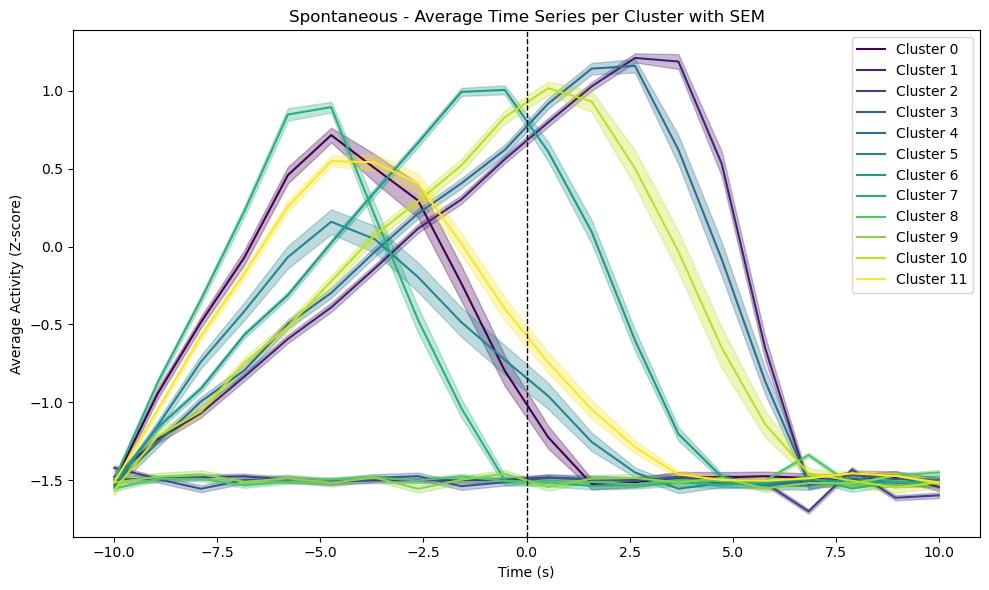

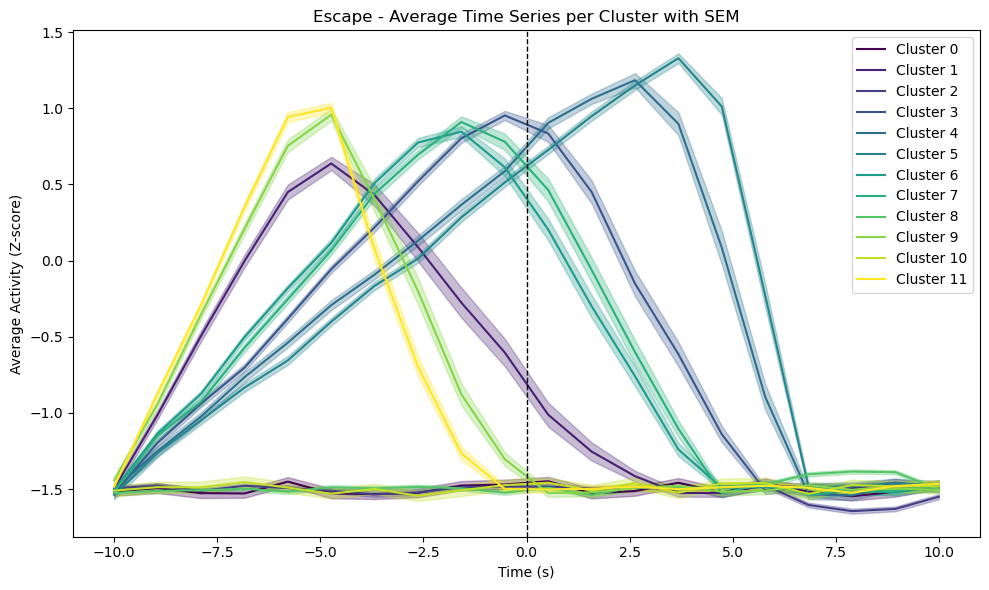

In [102]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import sem
from collections import defaultdict

def get_cluster_average_time_series(C1_activity, C2_activity, clusters):
    # Determine the number of clusters
    n_clusters = len(set(clusters))

    # Initialize dictionaries to hold time series for each cluster in each condition
    C1_cluster_data = defaultdict(list)
    C2_cluster_data = defaultdict(list)

    # Separate cells by cluster
    for (region1, neuron_id1, ts1, peak_time1), (region2, neuron_id2, ts2, peak_time2), cluster_id in zip(C1_activity, C2_activity, clusters):
        C1_cluster_data[cluster_id].append(ts1)
        C2_cluster_data[cluster_id].append(ts2)

    # Compute the average and SEM time series for each cluster
    C1_cluster_avg = {}
    C2_cluster_avg = {}
    C1_cluster_sem = {}
    C2_cluster_sem = {}
    for cluster_id in range(n_clusters):
        C1_cluster_avg[cluster_id] = np.mean(C1_cluster_data[cluster_id], axis=0)
        C2_cluster_avg[cluster_id] = np.mean(C2_cluster_data[cluster_id], axis=0)
        C1_cluster_sem[cluster_id] = sem(C1_cluster_data[cluster_id], axis=0)
        C2_cluster_sem[cluster_id] = sem(C2_cluster_data[cluster_id], axis=0)
    
    return C1_cluster_avg, C2_cluster_avg, C1_cluster_sem, C2_cluster_sem

# Get the average and SEM time series for each cluster
C1_cluster_avg, C2_cluster_avg, C1_cluster_sem, C2_cluster_sem = get_cluster_average_time_series(C1_activity, C2_activity, clusters)

# Define x-axis time points
time_points = np.linspace(-10, 10, C1_cluster_avg[0].shape[0])

# Define colors for clusters
colors = plt.cm.viridis(np.linspace(0, 1, len(C1_cluster_avg)))

# Plotting for C1 ("Spontaneous")
plt.figure(figsize=(10, 6))
for cluster_id, color in enumerate(colors):
    plt.plot(time_points, C1_cluster_avg[cluster_id], color=color, label=f'Cluster {cluster_id}')
    plt.fill_between(
        time_points,
        C1_cluster_avg[cluster_id] - C1_cluster_sem[cluster_id],
        C1_cluster_avg[cluster_id] + C1_cluster_sem[cluster_id],
        color=color,
        alpha=0.3
    )

# Add labels, legend, and line at time 0
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.title("Spontaneous - Average Time Series per Cluster with SEM")
plt.xlabel("Time (s)")
plt.ylabel("Average Activity (Z-score)")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

# Plotting for C2 ("Escape")
plt.figure(figsize=(10, 6))
for cluster_id, color in enumerate(colors):
    plt.plot(time_points, C2_cluster_avg[cluster_id], color=color, label=f'Cluster {cluster_id}')
    plt.fill_between(
        time_points,
        C2_cluster_avg[cluster_id] - C2_cluster_sem[cluster_id],
        C2_cluster_avg[cluster_id] + C2_cluster_sem[cluster_id],
        color=color,
        alpha=0.3
    )

# Add labels, legend, and line at time 0
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.title("Escape - Average Time Series per Cluster with SEM")
plt.xlabel("Time (s)")
plt.ylabel("Average Activity (Z-score)")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


In [95]:
from collections import defaultdict
import pandas as pd

def calculate_proportions_by_region(C1_activity, clusters):
    # Initialize a dictionary to hold counts per region and cluster
    region_cluster_counts = defaultdict(lambda: defaultdict(int))
    region_counts = defaultdict(int)

    # Iterate over the data to populate region and cluster counts
    for (region, neuron_id, time_series, peak_time), cluster_id in zip(C1_activity, clusters):
        region_cluster_counts[region][cluster_id] += 1
        region_counts[region] += 1

    # Calculate the proportion of cells in each cluster within each region
    region_cluster_proportions = {}
    for region, cluster_count_dict in region_cluster_counts.items():
        total_cells_in_region = region_counts[region]
        region_cluster_proportions[region] = {cluster_id: count / total_cells_in_region
                                              for cluster_id, count in cluster_count_dict.items()}
    
    return region_cluster_proportions

# Example usage with C1_activity and clusters
region_cluster_proportions = calculate_proportions_by_region(C1_activity, clusters)

# Convert to DataFrame for easier viewing and analysis
region_cluster_df = pd.DataFrame(region_cluster_proportions).fillna(0)  # Fill NaNs with 0 for clusters with no cells
region_cluster_df.index.name = "Cluster"
region_cluster_df.columns.name = "Region"

print("Proportion of cells within each region that fall into each cluster:")
print(region_cluster_df)


Proportion of cells within each region that fall into each cluster:
Region         DN        FF       VTA       CeA        M1
Cluster                                                  
1        0.343675  0.221538  0.330317  0.170681  0.258621
0        0.431981  0.286154  0.352941  0.207158  0.231801
2        0.224344  0.492308  0.316742  0.622161  0.509579


In [96]:
region_cluster_df

Region,DN,FF,VTA,CeA,M1
Cluster,,,,,
1,0.343675,0.221538,0.330317,0.170681,0.258621
0,0.431981,0.286154,0.352941,0.207158,0.231801
2,0.224344,0.492308,0.316742,0.622161,0.509579


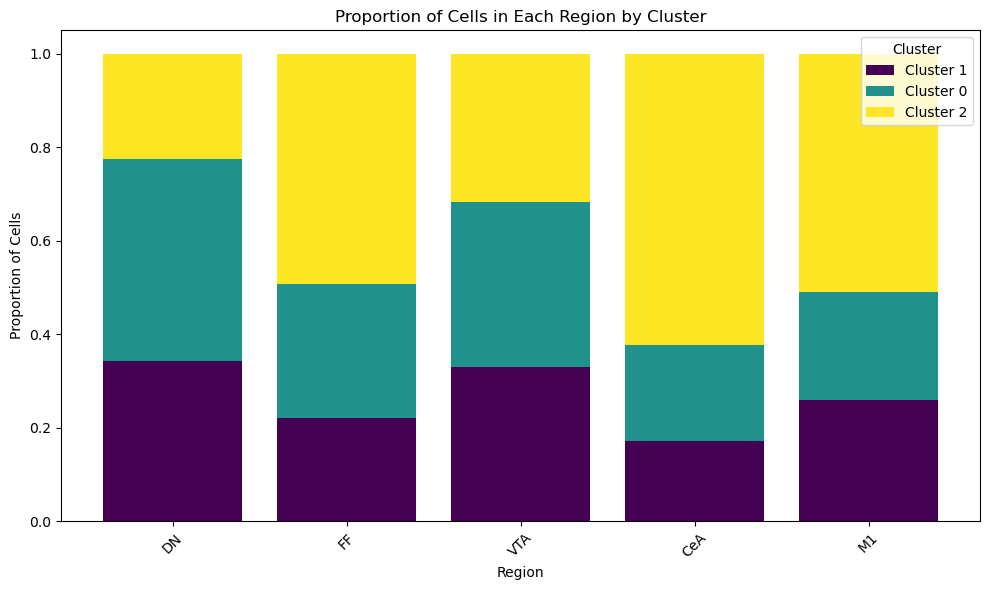

In [97]:

def plot_region_cluster_proportions(region_cluster_df):
    # Plot settings
    fig, ax = plt.subplots(figsize=(10, 6))

    # Colors for each cluster (can be adjusted for clarity)
    colors = plt.cm.viridis(np.linspace(0, 1, len(region_cluster_df.index)))

    # Plotting stacked bars for each region
    bottom = np.zeros(len(region_cluster_df.columns))  # Initialize bottom for stacking
    for cluster, color in zip(region_cluster_df.index, colors):
        ax.bar(
            region_cluster_df.columns, 
            region_cluster_df.loc[cluster], 
            bottom=bottom, 
            label=f"Cluster {cluster}", 
            color=color
        )
        # Update the bottom to stack the bars
        bottom += region_cluster_df.loc[cluster]

    # Labels and formatting
    ax.set_ylabel("Proportion of Cells")
    ax.set_xlabel("Region")
    ax.set_title("Proportion of Cells in Each Region by Cluster")
    ax.legend(title="Cluster")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Generate the plot with the calculated proportions DataFrame
plot_region_cluster_proportions(region_cluster_df)

In [98]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def generate_cluster_heatmaps(C1_activity, C2_activity, clusters, n_clusters):
    # Store averaged time series for each cluster in each condition
    cluster_averages_C1 = []
    cluster_averages_C2 = []
    
    for cluster_id in range(n_clusters):
        # Extract cells that belong to the current cluster for both conditions
        cluster_indices = [i for i, cluster in enumerate(clusters) if cluster == cluster_id]
        
        # Average time series for C1 and C2 within the current cluster
        cluster_avg_C1 = np.mean([C1_activity[i][2] for i in cluster_indices], axis=0)
        cluster_avg_C2 = np.mean([C2_activity[i][2] for i in cluster_indices], axis=0)
        
        # Append to the list of averaged time series
        cluster_averages_C1.append(cluster_avg_C1)
        cluster_averages_C2.append(cluster_avg_C2)
    
    # Convert lists to arrays for heatmap plotting
    cluster_averages_C1 = np.array(cluster_averages_C1)
    cluster_averages_C2 = np.array(cluster_averages_C2)
    
    # Plot heatmaps
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

    sns.heatmap(cluster_averages_C1, ax=axes[0], cmap="coolwarm", cbar=True, xticklabels=False, yticklabels=[f"Cluster {i+1}" for i in range(n_clusters)])
    axes[0].set_title("Spontaneous Condition (C1)")
    axes[0].axvline(x=pre_stim_points, color='black', linestyle='--', linewidth=1)

    sns.heatmap(cluster_averages_C2, ax=axes[1], cmap="coolwarm", cbar=True, xticklabels=False, yticklabels=[f"Cluster {i+1}" for i in range(n_clusters)])
    axes[1].set_title("Escape Condition (C2)")
    axes[1].axvline(x=pre_stim_points, color='black', linestyle='--', linewidth=1)

    # Set labels
    for ax in axes:
        ax.set_xlabel("Time (points)")
        ax.set_ylabel("Cluster")
    
    plt.tight_layout()
    plt.show()

# Call the function with your data and cluster information
generate_cluster_heatmaps(C1_activity, C2_activity, clusters, n_clusters)


NameError: name 'n_clusters' is not defined